In [1]:
import os
import yaml
from glob import glob
from tqdm import tqdm
from pprint import pprint
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
from astropy.visualization import make_lupton_rgb
from scipy.stats import chi2
from pyHalo.Halos.lens_cosmo import LensCosmo
from pyHalo.concentration_models import preset_concentration_models
from pyHalo.single_realization import SingleHalo

from mejiro.synthetic_image import SyntheticImage
from mejiro.exposure import Exposure
from mejiro.instruments.hst import HST
from mejiro.instruments.roman import Roman
from mejiro.instruments.lsst import LSST
from mejiro.instruments.hwo import HWO
from mejiro.utils import util

# read configuration file
with open('/grad/bwedig/mejiro/projects/pipeline/hwo.yaml', 'r') as f:
    config = yaml.load(f, Loader=yaml.SafeLoader)

Warning, 5 of 20000 bins contained negative fluxes; they have been set to zero.
Warning, 3590 of 20000 bins contained negative fluxes; they have been set to zero.
Warning, 293 of 2920 bins contained negative fluxes; they have been set to zero.


In [2]:
if config['dev']:
    config['pipeline_label'] += '_dev'

In [3]:
lenses = util.unpickle_all(os.path.join(config['data_dir'], config['pipeline_label'], '02'))
print(f'Found {len(lenses)} strong lens(es)')

name_snr_pairs = util.unpickle(os.path.join(config['data_dir'], config['pipeline_label'], 'snr/name_snr_pairs.pkl'))
snr_dict = dict(name_snr_pairs)

# Sort lenses by SNR, matching on exposure.synthetic_image.strong_lens.name
sorted_lenses = sorted(
    lenses,
    key=lambda lens: snr_dict.get(lens.name, -np.inf),
    reverse=True
)

Found 370 strong lens(es)


In [4]:
print(snr_dict)

{'hwo_00000001': 516.8631107969738, 'hwo_00000002': 432.5995255203777, 'hwo_00000000': 379.6359966473038, 'hwo_00000128': 444.8168484269825, 'hwo_00000129': 510.6195110278043, 'hwo_00000003': 411.3954178881559, 'hwo_00000004': 1371.57886800465, 'hwo_00000008': 657.8958086733913, 'hwo_00000011': 781.8921047010404, 'hwo_00000009': 384.6687644730664, 'hwo_00000013': 511.6907193175277, 'hwo_00000006': 1909.7308022019909, 'hwo_00000012': 593.870319569292, 'hwo_00000014': 1368.982895125931, 'hwo_00000007': 565.8947255758995, 'hwo_00000016': 405.48489486459096, 'hwo_00000017': 743.6006739823987, 'hwo_00000015': 753.6195325770489, 'hwo_00000018': 581.4591823152692, 'hwo_00000130': 432.491718903493, 'hwo_00000021': 542.6405356797112, 'hwo_00000131': 804.6032213674991, 'hwo_00000020': 342.92547982785226, 'hwo_00000029': 771.4053325074533, 'hwo_00000030': 340.93537127335696, 'hwo_00000010': 706.7583331400087, 'hwo_00000132': 460.32802785974513, 'hwo_00000133': 373.28562966461084, 'hwo_00000025': 

In [5]:
lens = sorted_lenses[2]
lens_no_subhalo = deepcopy(lens)

In [6]:
fov_arcsec = 4

In [7]:
synth_hwo_no_subhalo = SyntheticImage(strong_lens=lens_no_subhalo,
                                     instrument=HWO(),
                                     fov_arcsec=fov_arcsec,
                                     band='I',
                                     pieces=True,
                                     verbose=True)
# synth_hwo_no_subhalo.plot()

Scene size: 4.004974987964455 arcsec, 699 pixels at pixel scale 0.005729577951308233 arcsec/pix


In [8]:
synth_hst_no_subhalo = SyntheticImage(strong_lens=lens_no_subhalo,
                                 instrument=HST(),
                                 fov_arcsec=fov_arcsec,
                                 band='F814W',
                                 pieces=True,
                                 verbose=True)
# synth_hst_no_subhalo.plot()

Scene size: 4.08 arcsec, 51 pixels at pixel scale 0.08 arcsec/pix


In [9]:
synth_lsst_no_subhalo = SyntheticImage(strong_lens=lens_no_subhalo,
                                 instrument=LSST(),
                                 fov_arcsec=fov_arcsec,
                                 band='i',
                                 pieces=True,
                                 verbose=True)
# synth_lsst_no_subhalo.plot()

Scene size: 4.2 arcsec, 21 pixels at pixel scale 0.2 arcsec/pix


In [10]:
exposure_hwo_no_subhalo = Exposure(synthetic_image=synth_hwo_no_subhalo,
                        exposure_time=5400,
                        engine='galsim',
                        verbose=True)
# exposure_hwo_no_subhalo.plot()

Exposure calculation time with galsim engine: 0.14 s


In [11]:
exposure_hst_no_subhalo = Exposure(synthetic_image=synth_hst_no_subhalo,
                    exposure_time=None,
                    engine='lenstronomy',
                    verbose=True)
# exposure_hst.plot()

{'kwargs_numerics': {'supersampling_factor': 1, 'compute_mode': 'regular'}, 'noise': True, 'obs_config_kwargs': {'band': 'WFC3_F160W', 'psf_type': 'PIXEL', 'coadd_years': None}}
Exposure calculation time with lenstronomy engine: 0.014 s


In [12]:
exposure_lsst_no_subhalo = Exposure(synthetic_image=synth_lsst_no_subhalo,
                    exposure_time=None,
                    engine='lenstronomy',
                    engine_params={
                'obs_config_kwargs': {
                    'band': 'i', 
                    'psf_type': 'GAUSSIAN', 
                    'coadd_years': 10}},
                    verbose=True)
# exposure_lsst.plot()

{'obs_config_kwargs': {'band': 'i', 'psf_type': 'GAUSSIAN', 'coadd_years': 10}, 'kwargs_numerics': {'supersampling_factor': 1, 'compute_mode': 'regular'}, 'noise': True}
Exposure calculation time with lenstronomy engine: 0.005 s


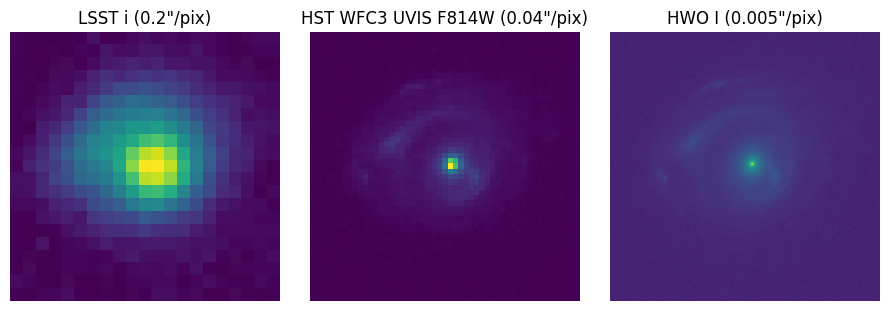

In [31]:
f, ax = plt.subplots(1, 3, figsize=(9, 3), constrained_layout=True)
ax[0].imshow(exposure_lsst_no_subhalo.exposure)
ax[0].set_title('LSST i (0.2"/pix)')
ax[1].imshow(exposure_hst_no_subhalo.exposure)
ax[1].set_title('HST WFC3 UVIS F814W (0.04"/pix)')
ax[2].imshow(np.log10(exposure_hwo_no_subhalo.exposure))
ax[2].set_title('HWO I (0.005"/pix)')
for a in ax.flatten():
    a.axis('off')
plt.savefig('/grad/bwedig/mejiro/projects/hwo/figures/compare_instruments.png', dpi=600)
plt.show()

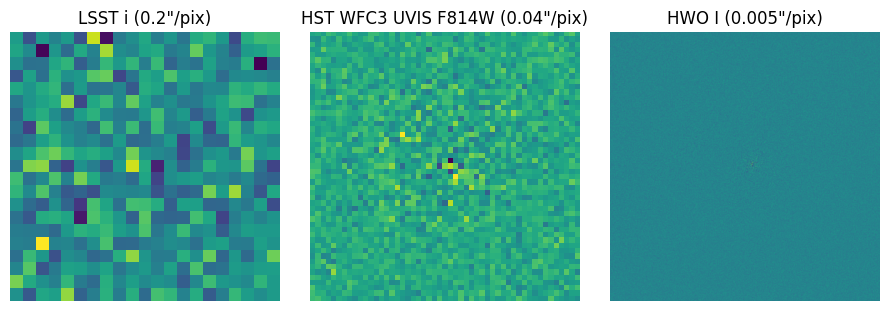

In [14]:
f, ax = plt.subplots(1, 3, figsize=(9, 3), constrained_layout=True)
ax[0].imshow(exposure_lsst_no_subhalo.noise)
ax[0].set_title('LSST i (0.2"/pix)')
ax[1].imshow(exposure_hst_no_subhalo.noise)
ax[1].set_title('HST WFC3 UVIS F814W (0.04"/pix)')
ax[2].imshow(exposure_hwo_no_subhalo.noise)
ax[2].set_title('HWO I (0.005"/pix)')
for a in ax.flatten():
    a.axis('off')
plt.show()

In [15]:
# calculate image position and set subhalo position
image_x, image_y = synth_hwo_no_subhalo.get_image_positions(pixel=False)
image_distance = np.sqrt(image_x ** 2 + image_y ** 2)
image_index = np.argmax(image_distance)
# image_index = np.random.randint(0, len(image_distance))
halo_x = image_x[image_index]
halo_y = image_y[image_index]

print(f'Image position: ({image_x[image_index]}, {image_y[image_index]})')

Image position: (-0.663607483755572, -0.5069962508150044)


In [16]:
m200 = 1e8

exposures = [exposure_lsst_no_subhalo, exposure_hst_no_subhalo, exposure_hwo_no_subhalo]
exposures_no_subhalo = [exposure_lsst_no_subhalo, exposure_hst_no_subhalo, exposure_hwo_no_subhalo]
instruments = [LSST(), HST(), HWO()]
bands = ['i', 'F814W', 'I']
engines = ['lenstronomy', 'lenstronomy', 'galsim']
residuals = []
coords = []

for exposure, exposure_no_subhalo, instrument, band, engine in zip(exposures, exposures_no_subhalo, instruments, bands, engines):
    source_exposure = exposure.source_exposure
    noise = exposure.noise

    # snr_array = np.nan_to_num(source_exposure / np.sqrt(exposure.exposure))
    # snr_threshold = np.quantile(snr_array, 0.9)
    # masked_snr_array = np.ma.masked_where(snr_array <= snr_threshold, snr_array)
    # mask = np.ma.getmask(masked_snr_array)
    # masked_exposure_no_subhalo = np.ma.masked_array(exposure.exposure, mask=mask)

    # pixels_unmasked = masked_snr_array.count()
    # dof = pixels_unmasked - 3
    # rv = chi2(dof)
    # threshold_chi2 = rv.isf(0.001)

    center_x = halo_x
    center_y = halo_y

    pyhalo_lens_cosmo = LensCosmo(lens.z_lens, lens.z_source)
    astropy_class = pyhalo_lens_cosmo.cosmo
    c_model, kwargs_concentration_model = preset_concentration_models('DIEMERJOYCE19')
    kwargs_concentration_model['scatter'] = False
    kwargs_concentration_model['cosmo'] = astropy_class
    concentration_model = c_model(**kwargs_concentration_model)
    truncation_model = None
    kwargs_halo_model = {
        'truncation_model': truncation_model,
        'concentration_model': concentration_model,
        'kwargs_density_profile': {}
    }
    single_halo = SingleHalo(halo_mass=m200,
                                x=center_x, y=center_y,
                                mdef='NFW',
                                z=lens.z_lens, zlens=lens.z_lens, zsource=lens.z_source,
                                subhalo_flag=True,
                                kwargs_halo_model=kwargs_halo_model,
                                astropy_instance=lens.cosmo,
                                lens_cosmo=pyhalo_lens_cosmo)
    c = single_halo.halos[0].c

    lens_with_subhalo = deepcopy(lens)
    lens_with_subhalo.add_realization(single_halo)
    synth = SyntheticImage(lens_with_subhalo,
                            instrument=instrument,
                            band=band,
                            fov_arcsec=fov_arcsec,
                            verbose=True)
    exposure = Exposure(synth,
                        exposure_time=5400,
                        engine=engine,
                        engine_params={
                            'noise': noise
                        },
                        verbose=True)
    
    residual = exposure.exposure - exposure_no_subhalo.exposure
    residuals.append(residual)

    coords_x, coords_y = synth.coords.map_coord2pix(halo_x, halo_y)
    coords.append((coords_x, coords_y))

Scene size: 4.2 arcsec, 21 pixels at pixel scale 0.2 arcsec/pix
{'noise': array([[ 2.16624250e-02, -1.26326030e-01,  1.57550762e-02,
        -3.04112808e-02,  1.53398540e-02, -1.24960721e-01,
         2.04533548e-01, -2.33561294e-01, -4.45161882e-02,
        -6.94914022e-03,  4.52652491e-02, -3.93466893e-02,
         7.61491454e-03, -5.60386006e-02,  5.27421090e-02,
         7.25362499e-02,  1.30297427e-02, -1.39716063e-01,
         5.76611864e-02,  8.89025379e-02,  8.47005945e-02],
       [ 3.74525212e-02, -1.43931723e-02, -2.44101907e-01,
         9.12293734e-03, -7.79760548e-02,  4.74276582e-02,
        -3.27419139e-02,  1.77293923e-01, -8.95912504e-03,
        -2.67714306e-02,  3.64833842e-02,  4.86200227e-02,
        -4.93353341e-02, -2.74591659e-02,  1.26629257e-01,
         1.14056031e-02, -3.04725155e-02, -9.70045780e-02,
         2.05720711e-02,  3.28743862e-02,  6.49134547e-02],
       [-5.36238397e-03, -6.66335371e-02, -6.38902098e-02,
         4.14746409e-02,  7.30455145e-0

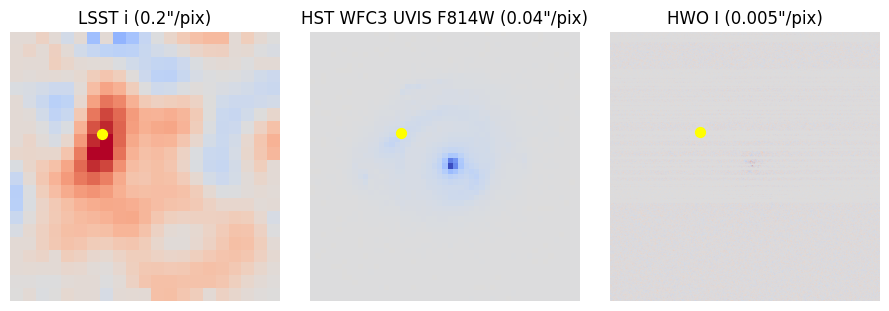

In [17]:
from matplotlib.colors import CenteredNorm

f, ax = plt.subplots(1, 3, figsize=(9, 3), constrained_layout=True)
ax[0].imshow(residuals[0], cmap='coolwarm', norm=CenteredNorm())
ax[0].scatter(coords[0][0], coords[0][1], color='yellow', s=50, label='Subhalo Position')
ax[0].set_title('LSST i (0.2"/pix)')
ax[1].imshow(residuals[1], cmap='coolwarm', norm=CenteredNorm())
ax[1].scatter(coords[1][0], coords[1][1], color='yellow', s=50, label='Subhalo Position')
ax[1].set_title('HST WFC3 UVIS F814W (0.04"/pix)')
ax[2].imshow(residuals[2], cmap='coolwarm', norm=CenteredNorm())
ax[2].scatter(coords[2][0], coords[2][1], color='yellow', s=50, label='Subhalo Position')
ax[2].set_title('HWO I (0.005"/pix)')
for a in ax.flatten():
    a.axis('off')
plt.show()